# Robinson Crusoe or how to build your own model

With ``respy`` you are able to prototype a model similar to Keane and Wolpin (1997) in minutes. In this notebook we will implement a model of a common theme in economics - the Robinson Crusoe economy - as a discrete choice dynamic programming model. Throughout the notebook you find indented text which tell parts of Robinson's story and motivate the model.

We hope that you don't missinterpret the fact that we explain ``respy`` using such a simplistic model. ``respy`` is not a toy and can just as well solve real models from published papers. It's just easier to explain respy in a situation where we don't have to explain a complicated model at the same time. 

In [1]:
%matplotlib inline

import io
import matplotlib.pyplot as plt
import pandas as pd
import respy as rp
import yaml
import seaborn as sns

from pathlib import Path
from time import time

## Introduction

> After setting sail against his parents wishes, being captured by pirates, escaping from them, building a plantation and setting sail again to capture slaves in Africa, [Robinson Crusoe](https://en.wikipedia.org/wiki/Robinson_Crusoe) stranded on a small island. He is alone with one dog, two cats and only some supplies. To make ends meet he goes fishing and if he is too tired he will relax in his hammock made of old canvas.

In the discrete choice dynamic programming model, Robinson chooses every period between fishing, $a = 0$, and the hammock, $a = 1$, to maximize the expected present value of utility over all choices. The reward or utility of a choice, $U(s_t, a_t)$, depends on the state $s_t$, which contains information on the individual's characteristics, and the chosen alternative $a_t$. For working alternatives like fishing utility consists of two components, a wage and a non-pecuniary component.

$$
    U(s_t, a_t) = W(s_t, a_t) + N(s_t, a_t)
$$

For non-working alternatives like the hammock, $W(s_t, a_t) = 0$. The wage is defined as

$$\begin{align}
        W(s_t, a_t)  &= r_a \exp\{x^w_{at} \beta^w_a + \epsilon_{at}\}\\
    \ln(W(s_t, a_t)) &= \ln(r_a) + x^w_{at} \beta^w_a + \epsilon_{at}
\end{align}$$


where $r_a$ is normally a market rental price for the skill units generated in the exponential expression. Another interpretation is that $ln(r_a)$ is simply the constant in the skill units. The skill units are generated by two components. $x^w_{at}$ and $\beta^w_a$ are the choice- and time-dependent covariates and parameters related to the wage signaled by superscript $w$. The last term, $\epsilon_{at}$ is a random shock.

The non-pecuniary rewards for working alternatives are simply a vector dot product of covariates $x_t^w$ and parameters $\beta^w$. The superscript $w$ signals that the components belong to working alternatives.

$$
    N^w(s_t, a_t) = x_t^w\beta^w
$$

The non-pecuniary reward for non-working alternatives is very similar except that the shocks enter the equation additively. Superscript $n$ stands for non-pecuniary.

$$
    N^n(s_t, a_t) = x_t^n\beta^n + \epsilon_{at}
$$

How can we express the equations and parameters with ``respy``? The following cell contains the code to write a ``.csv`` file which is the cornerstone of a model and contains all parameters of the model and some other specification. It is quickly written and easily loaded with ``pandas``.

In [2]:
%%writefile robinson-crusoe.csv

category,name,value
delta,delta,0.95
wage_fishing,exp_fishing,0.1
nonpec_fishing,constant,-1
nonpec_hammock,constant,2.5
nonpec_hammock,not_fishing_last_period,-1
shocks_sdcorr,sd_fishing,1
shocks_sdcorr,sd_hammock,1
shocks_sdcorr,corr_hammock_fishing,-0.2
lagged_choice_1_hammock,constant,1

Writing robinson-crusoe.csv


In [4]:
params = pd.read_csv("robinson-crusoe.csv", index_col=["category", "name"])
params

value
category                name                          
delta                   delta                     0.95
wage_fishing            exp_fishing               0.10
nonpec_fishing          constant                 -1.00
nonpec_hammock          constant                  2.50
                        not_fishing_last_period  -1.00
shocks_sdcorr           sd_fishing                1.00
                        sd_hammock                1.00
                        corr_hammock_fishing     -0.20
lagged_choice_1_hammock constant                  1.00

The parameters :class:`pd.DataFrame` contains a two-level :class:`pd.MultiIndex` to group parameters in categories. ``name`` should be uniquely assigned in each category or otherwise only the sum of identically named parameters is identified. ``value`` contains the value of the parameter. Note that we named Robinson's alternatives ``"fishing"`` and ``"hammock"`` and we have to use the names consistently. As long as you stick to lowercase letters separated by underscores, you can choose any name you want.

The parameter specification contains following entries:

- The first entry contains the discount factor of individuals.
- The second category ``"wage_fishing"`` contains the parameters of the log wage equation for fishing. The group contains only one name called ``"exp_fishing"`` where ``"exp_*"`` is an identifier in the model for experience accumulated in a certain alternative. ``respy`` requires that you respect those identifier of which there are not many and reference your alternatives consistently with the same name. If you stick to lowercase letters possibly separated by underscores, you are fine.
- The third category concerns the non-pecuniary reward of fishing!!!!!!!!!!!!!!!!!!!!!!!!

In [3]:
%%writefile robinson-crusoe.yaml

estimation_draws: 200
estimation_seed: 500
estimation_tau: 50
interpolation_points: -1
n_periods: 10
simulation_agents: 1_000
simulation_seed: 132
solution_draws: 500
solution_seed: 456
covariates:
    constant: "1"
    not_fishing_last_period: "lagged_choice_1 != 'fishing'"

Overwriting robinson-crusoe.yaml


In [4]:
params = pd.read_csv("robinson-crusoe.csv", index_col=["category", "name"])
options = yaml.safe_load(Path("robinson-crusoe.yaml").read_text())

In [5]:
params

value
category                name                          
delta                   delta                     0.95
wage_fishing            exp_fishing               0.10
nonpec_fishing          constant                 -1.00
nonpec_hammock          constant                  2.50
                        not_fishing_last_period  -1.00
shocks_sdcorr           sd_fishing                1.00
                        sd_hammock                1.00
                        corr_hammock_fishing     -0.20
lagged_choice_1_hammock constant                  1.00

In [6]:
options

{'estimation_draws': 200,
 'estimation_seed': 500,
 'estimation_tau': 50,
 'interpolation_points': -1,
 'n_periods': 10,
 'simulation_agents': 1000,
 'simulation_seed': 132,
 'solution_draws': 500,
 'solution_seed': 456,
 'covariates': {'constant': '1',
  'not_fishing_last_period': "lagged_choice_1 != 'fishing'"}}

## Simulating a Model

In [7]:
simulate = rp.get_simulate_func(params, options)

In [8]:
df = simulate(params)

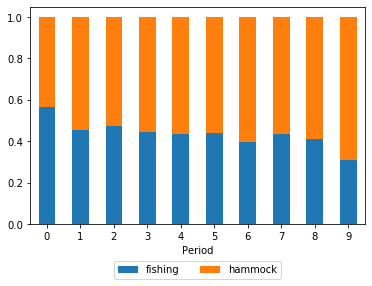

In [9]:
fig, ax = plt.subplots()

df.groupby("Period").Choice.value_counts(normalize=True).unstack().plot.bar(
    stacked=True, ax=ax
)

plt.xticks(rotation="horizontal")

plt.legend(loc="lower center", bbox_to_anchor=(0.5,-0.275), ncol=2)

plt.show()
plt.close()

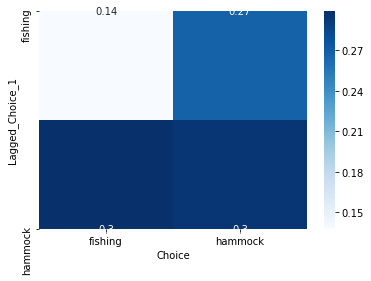

In [10]:
data = pd.crosstab(df.Lagged_Choice_1, df.Choice, normalize=True)
sns.heatmap(data, cmap="Blues", annot=True)

## A small extension

> At some point Crusoe notices that a group of cannibals occasionally visits the island and celebrate one of their dark rituals. But then, a prisoner can escape and becomes Crusoe's new friend Friday whom he teaches English. In return Friday can share his knowledge once to help Robinson improve his fishing skills, but that is only possible after Robinson tried at least once to go fishing.

- show that there are two possible ways to implement Friday, experience and lagged_choice
- show that there are two possible ways to restrict talking to Friday to a one-time choice

In [11]:
%%writefile robinson-crusoe.csv

category,name,value
delta,delta,0.95
wage_fishing,exp_fishing,0.1
wage_fishing,contemplation_with_friday,0.4
nonpec_fishing,constant,-1
nonpec_friday,constant,-1
nonpec_friday,not_fishing_last_period,-1
nonpec_hammock,constant,2.5
nonpec_hammock,not_fishing_last_period,-1
shocks_sdcorr,sd_fishing,1
shocks_sdcorr,sd_friday,1
shocks_sdcorr,sd_hammock,1
shocks_sdcorr,corr_friday_fishing,0
shocks_sdcorr,corr_hammock_fishing,-0.2
shocks_sdcorr,corr_hammock_friday,0
lagged_choice_1_hammock,constant,1
meas_error,sd_fishing,1e-6

Overwriting robinson-crusoe.csv


In [12]:
%%writefile robinson-crusoe.yaml

estimation_draws: 200
estimation_seed: 500
estimation_tau: 50
interpolation_points: -1
n_periods: 10
simulation_agents: 1_000
simulation_seed: 132
solution_draws: 500
solution_seed: 456
covariates:
    constant: "1"
    contemplation_with_friday: "exp_friday == 1 and exp_fishing >= 1"
    not_fishing_last_period: "lagged_choice_1 != 'fishing'"
inadmissible_states:
    friday: [
        "period < 2",
        "exp_fishing == 0"
    ]

Overwriting robinson-crusoe.yaml


In [13]:
params = pd.read_csv("robinson-crusoe.csv", index_col=["category", "name"])
options = yaml.safe_load(Path("robinson-crusoe.yaml").read_text())

In [14]:
simulate = rp.get_simulate_func(params, options)

In [15]:
df = simulate(params)

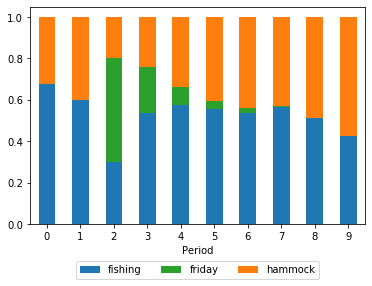

In [16]:
fig, ax = plt.subplots()

df.groupby("Period").Choice.value_counts(normalize=True).unstack().plot.bar(
    stacked=True, ax=ax, color=["C0", "C2", "C1"],
)

plt.xticks(rotation="horizontal")

plt.legend(loc="lower center", bbox_to_anchor=(0.5,-0.275), ncol=3)

plt.show()
plt.close()

## Estimating Parameters

To estimate model parameters via maximum likelihood, ``respy`` relies on [``estimagic``](https://github.com/OpenSourceEconomics/estimagic), an open-source tool to estimate structural models and more. That way, respy only has to implement the likelihood function of your model, the optimization and standard error calculation is done by estimagic. 

Unlike other optimization libraries, estimagic does not optimize over a simple vector of parameters, but instead stores parameters in a DataFrame, which makes it easier to parse them into the quantities we need, store lower and upper bounds together with parameters and express constraints on the parameters. 

For ``estimagic``, we need to pass constraints on the parameters in a list containing dictionaries. Each dictionary is a constraint. A constraint includes two components: First, we need to tell ``estimagic`` which paramters we want to constrain. This is achieved by specifying an index location which will be passed to `df.loc`. Then, define the type of the constraint. Here, we only impose the constraint that the shock parameters have to be valid variances and correlations.

Optionally, we can add a column ``"group"`` which is identical to the category column. The estimagic dashboard will then contain one parameter convergence plot per group instead of plotting all parameters in the same figure. Since respy has quite many parameters, this will make the plots much more readable.

In [17]:
from estimagic.optimization.optimize import maximize

In [18]:
constr = [
    {"loc": "shocks_sdcorr", "type": "sdcorr"}, 
    {"loc": "delta", "type": "fixed", "value": 0.95}
]

params["group"] = params.index.get_level_values('category')

crit_func = rp.get_crit_func(params, options, df)
crit_func(params)


-17.238549136178044

In [19]:
results, params = maximize(
    crit_func, params, 
    "scipy_L-BFGS-B", 
    algo_options={"maxfun": 1}, 
    constraints=constr, 
    dashboard=False
)

If we hadn't limited the optimization to just one function evaluation, 
params would contain the estimated parameters and results and results would contain additional information on the optimization. 

If we hadn't set ``dashboard=False``, the call to maximize would have opened a browser window with the beautiful estimagic dashboard. Try it out if you run this notebook locally.